<a href="https://colab.research.google.com/github/quynhu-d/hse_risk_management_1/blob/main/RM_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект

Команда:
- Данг Куинь Ньы
- Каган Елизавета
- Ширшов Максим
- Кожевников Николай
- Сагало Екатерина

## Библиотеки

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import yfinance as yf

import sys
import warnings
warnings.simplefilter("ignore")


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder = '/content/drive/MyDrive/RM_project/'
data_folder = '/content/drive/MyDrive/RM_project/data/'

## Часть 1: Сбор данных

В этом ноутбуке все необходимые данные собираются из различных источников и сохраняются в единую табличку.

Необходимо собрать следующие данные:
1.	Процентные ставки на разные сроки (от 0 до 30 лет) за период с 1 января 2015 г. по 1 января 2023 г.
2.	Описания 5 государственных облигаций РФ (расписания выплат).\
Критерии — государственные облигации с полностью известными размерами выплат (не привязанные к показателям), без оферт, со сроком погашения после 1 января 2023 г.
3.	Рыночные котировки этих облигаций за период с 1 января 2015 г. по 1 января 2023 г.
4.	Котировки 10 акций за тот же период.
5.	Значения индекса ММВБ, индекса РТС, цены на нефть Brent и курса доллара и евро за тот же период.
6.	Котировки фьючерса и опционов на фьючерс на один выбранный актив из предыдущего пункта — выбрать один торговый день за 2022 год. Срок погашения и фьючерса, и опционов взять ближайшие к выбранному дню, но не ближе, чем 1 месяц.


**Период:** 01.01.2015 - 31.12.2022

In [ ]:
start_date = '2015-01-01'
end_date = '2022-12-31'

data = pd.DataFrame()
data['Date'] = pd.date_range(start_date, end_date)
data.set_index('Date', inplace=True)

In [ ]:
data.shape

(2922, 0)

### Индексы, курсы валют, металлы и т.д.

* Курс доллара: https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.01.2015&UniDbQuery.To=31.12.2022

* Курс евро: https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01239&UniDbQuery.From=01.01.2015&UniDbQuery.To=31.12.2022

* Нефть: https://investfunds.ru/indexes/624/

* Индекс МосБиржи: https://investfunds.ru/indexes/216/ , https://www.moex.com/ru/index/IMOEX/archive/?from=2015-01-01&till=2022-12-31&sort=TRADEDATE&order=desc

* Индекс РТС: https://investfunds.ru/indexes/218/ ,
https://www.moex.com/ru/index/RTSI/archive/?from=2015-01-01&till=2022-12-31&sort=TRADEDATE&order=desc

* Металлы (платина,золото, серебро): https://www.cbr.ru/hd_base/metall/metall_base_new/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2015&UniDbQuery.To=31.12.2022&UniDbQuery.Gold=true&UniDbQuery.Silver=true&UniDbQuery.Platinum=true&UniDbQuery.so=1

* Кривая бескупонной доходности на разные сроки: http://www.cbr.ru/hd_base/zcyc_params/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2015&UniDbQuery.To=31.12.2022

Кривая бескупонной доходности (КБД Московской биржи) представляет собой общепринятый способ описания временной структуры процентных ставок для однородных финансовых инструментов (долговых ценных бумаг) с одинаковыми качественными характеристиками, в том числе сходного кредитного качества.

In [ ]:
'''tickers_list_1 = ['RUB=X', 'EURRUB=X', 'BZ=F', 'IMOEX.ME', 'GC=F']

data_1 = yf.download(tickers=tickers_list_1,
            start=start_date, end=end_date,
            interval = '1d')['Adj Colse']
data_1.index = pd.to_datetime(data_1.index, format='%Y-%m-%d')'''

"tickers_list_1 = ['RUB=X', 'EURRUB=X', 'BZ=F', 'IMOEX.ME', 'GC=F']\n\ndata_1 = yf.download(tickers=tickers_list_1,\n            start=start_date, end=end_date,\n            interval = '1d')['Adj Colse']\ndata_1.index = pd.to_datetime(data_1.index, format='%Y-%m-%d')"

In [ ]:
for t in ['dollar.xlsx', 'euro.xlsx']:
    df = pd.read_excel(data_folder + t)[['Date', 'curs']]
    df.rename(columns={'curs':t.split('.')[0]}, inplace=True)
    data = data.join(df.set_index('Date'), on='Date', how='left')

In [ ]:
for t in ['brent.xlsx', 'imoex.xlsx', 'rtsi.xlsx']:
    df = pd.read_excel(data_folder + t)[['Date', 'value']]
    df.rename(columns={'value':t.split('.')[0]}, inplace=True)
    data = data.join(df.set_index('Date'), on='Date', how='left')

In [ ]:
df = pd.read_excel(data_folder + 'metall.xlsx')
data = data.join(df.set_index('Date'), on='Date', how='left')

In [ ]:
df = pd.read_excel(data_folder + 'zcc.xlsx')[['Date','peroid_0.25','peroid_0.5','peroid_1','peroid_5','peroid_10','peroid_15','peroid_20','peroid_30']]
data = data.join(df.set_index('Date'), on='Date', how='left')

In [ ]:
rename_columns_1 = {'dollar':'Курс доллара', 'euro':'Курс евро',
                    'brent':'Нефть', 'imoex':'МосБиржа', 'rtsi':'РТС',
                    'gold':'Золото', 'silver':'Серебро','platinum':'Платина',
                    'peroid_0.25':'КБД 0.25', 'peroid_0.5':'КБД 0.5', 'peroid_1':'КБД 1',
                    'peroid_5':'КБД 5', 'peroid_10':'КБД 10', 'peroid_15':'КБД 15', 'peroid_20':'КБД 20', 'peroid_30':'КБД 30'}
data.rename(columns=rename_columns_1, inplace=True)

### Облигации


https://www.moex.com/ru/bondization/calendar

### Акции

- Сбербанк
- Лукойл, Газпром, Роснефть, Татнефть, Норникель
- Аэрофлот
- Яндекс
- МТС
- ПИК

---
Источник: библиотека yfinance

---

Полезные ссылки\
https://www.finam.ru/quotes/stocks/russia/

https://bcs-express.ru/kotirovki-i-grafiki/vtbr

In [ ]:
tickers_list_2 = ['SBER.ME',
                'LKOH.ME', 'GAZP.ME', 'ROSN.ME', 'TATN.ME', 'GMKN.ME',
                'AFLT.ME', 'YNDX.ME', 'MTSS.ME', 'PIKK.ME']
print(f'Кол-во: {len(tickers_list_2)}')

col_name = 'Adj Close'
data_2 = yf.download(tickers=tickers_list_2,
            start=start_date, end=end_date,
            interval = '1d')[col_name]

data_2.index = pd.to_datetime(data_2.index, format='%Y-%m-%d')
rename_columns_2 = {'SBER.ME':'Сбербанк',
                    'LKOH.ME':'Лукойл', 'GAZP.ME':'Газпром', 'ROSN.ME':'Роснефть', 'TATN.ME':'Татнефть', 'GMKN.ME':'ГМК Норникель',
                    'AFLT.ME':'Аэрофлот', 'YNDX.ME':'Яндекс', 'MTSS.ME':'МТС', 'PIKK.ME':'ПИК'}
data_2.rename(columns=rename_columns_2, inplace=True)

data = data.join(data_2, on='Date', how='left')

Кол-во: 10
[*********************100%***********************]  10 of 10 completed


## Визуализация данных

In [ ]:
print(data.shape, '\n')

print(data.columns, '\n')

data.head(5)

(2922, 26) 

Index(['Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС', 'Золото',
       'Серебро', 'Платина', 'КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5', 'КБД 10',
       'КБД 15', 'КБД 20', 'КБД 30', 'Аэрофлот', 'Газпром', 'ГМК Норникель',
       'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк', 'Татнефть', 'Яндекс'],
      dtype='object') 



,Курс доллара,Курс евро,Нефть,МосБиржа,РТС,Золото,Серебро,Платина,КБД 0.25,КБД 0.5,...,Аэрофлот,Газпром,ГМК Норникель,Лукойл,МТС,ПИК,Роснефть,Сбербанк,Татнефть,Яндекс
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,56.2376,68.3681,55.84,NaN,NaN,2168.34,28.55,2187.78,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,56.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,53.11,1435.66,761.3,NaN,NaN,NaN,13.54,13.86,...,28.18047,87.328773,4379.78125,1377.073975,76.061943,155.316528,146.07901,33.267757,127.723228,1079.0


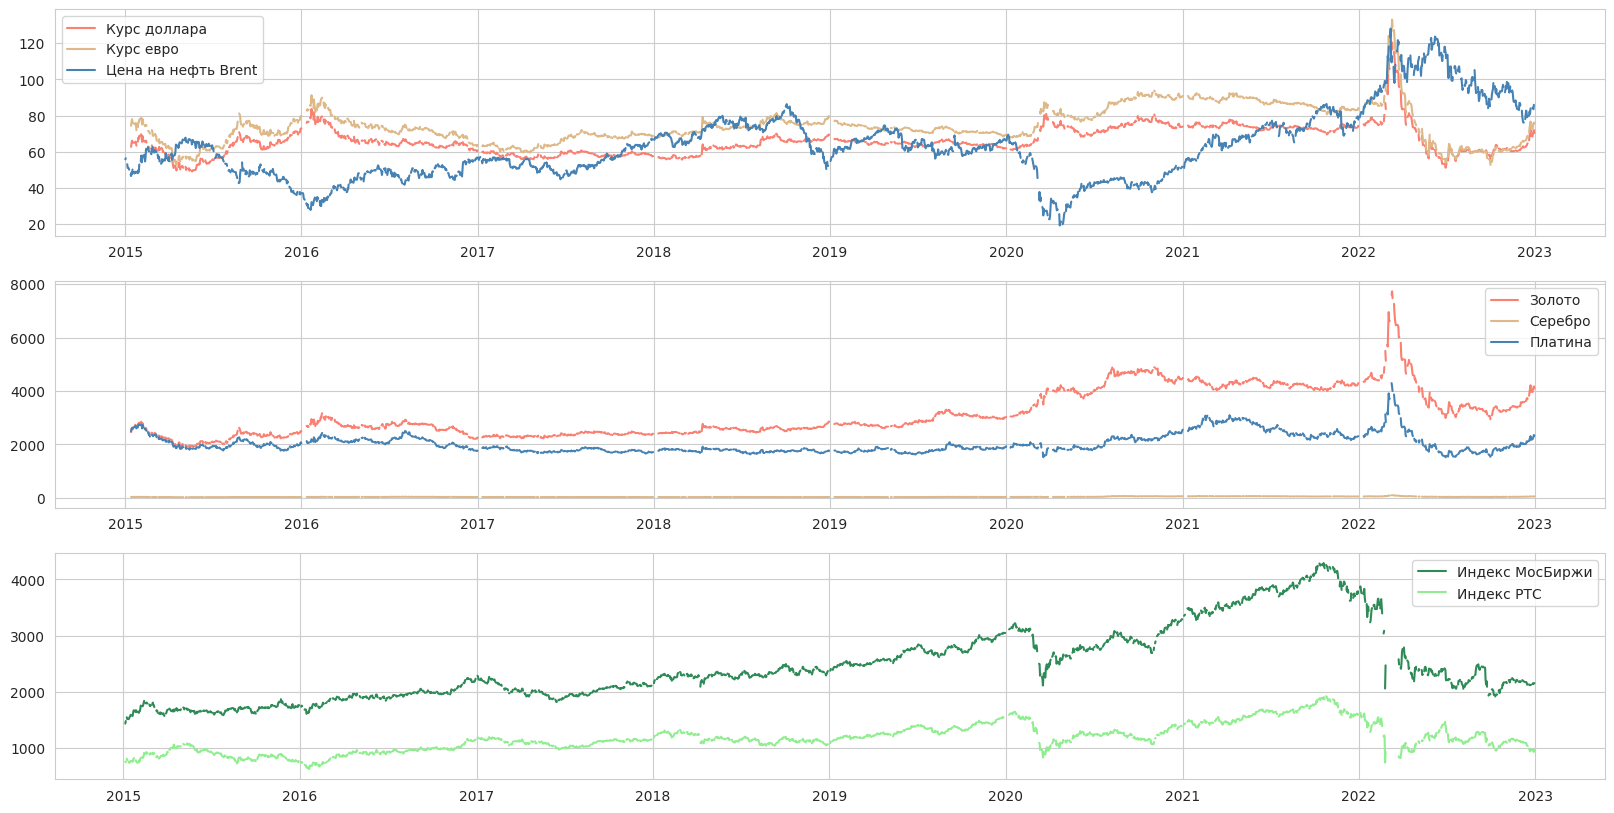

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(data['Курс доллара'], color='salmon', label='Курс доллара')
axs[0].plot(data['Курс евро'], color='burlywood', label='Курс евро')
axs[0].plot(data['Нефть'], color='steelblue', label='Цена на нефть Brent')
axs[0].legend()

axs[1].plot(data['Золото'], color='salmon', label='Золото')
axs[1].plot(data['Серебро'], color='burlywood', label='Серебро')
axs[1].plot(data['Платина'], color='steelblue', label='Платина')
axs[1].legend()

axs[2].plot(data['МосБиржа'], color='seagreen', label='Индекс МосБиржи')
axs[2].plot(data['РТС'], color='lightgreen', label='Индекс РТС')
axs[2].legend()

plt.show()

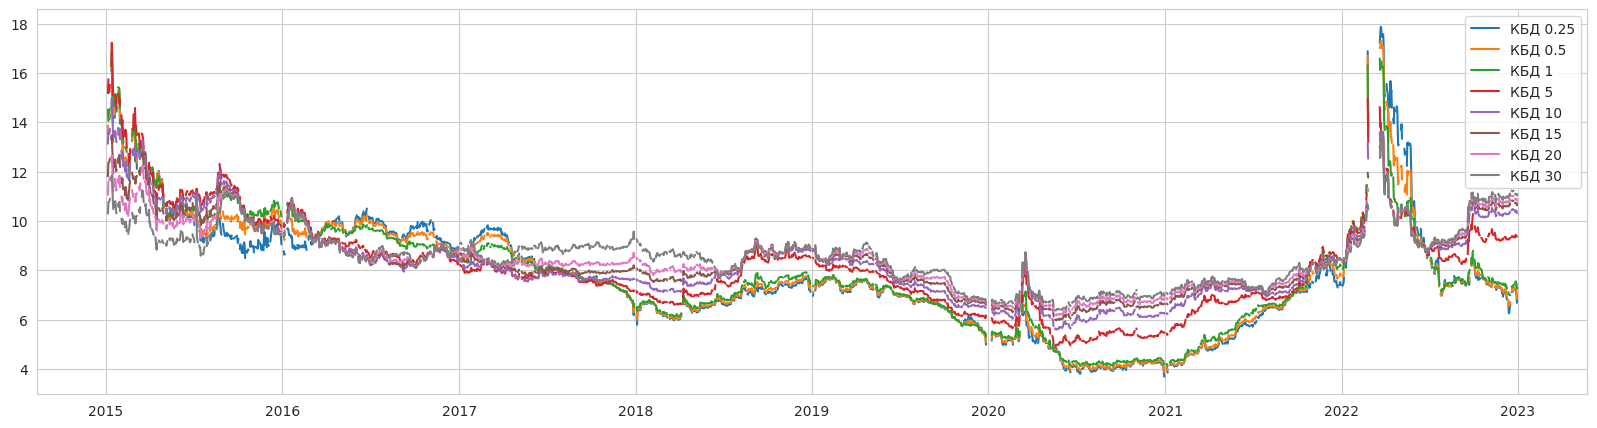

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

for i in ['КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5', 'КБД 10','КБД 15', 'КБД 20', 'КБД 30']:
    axs.plot(data[i], label=i)

axs.legend()
plt.show()


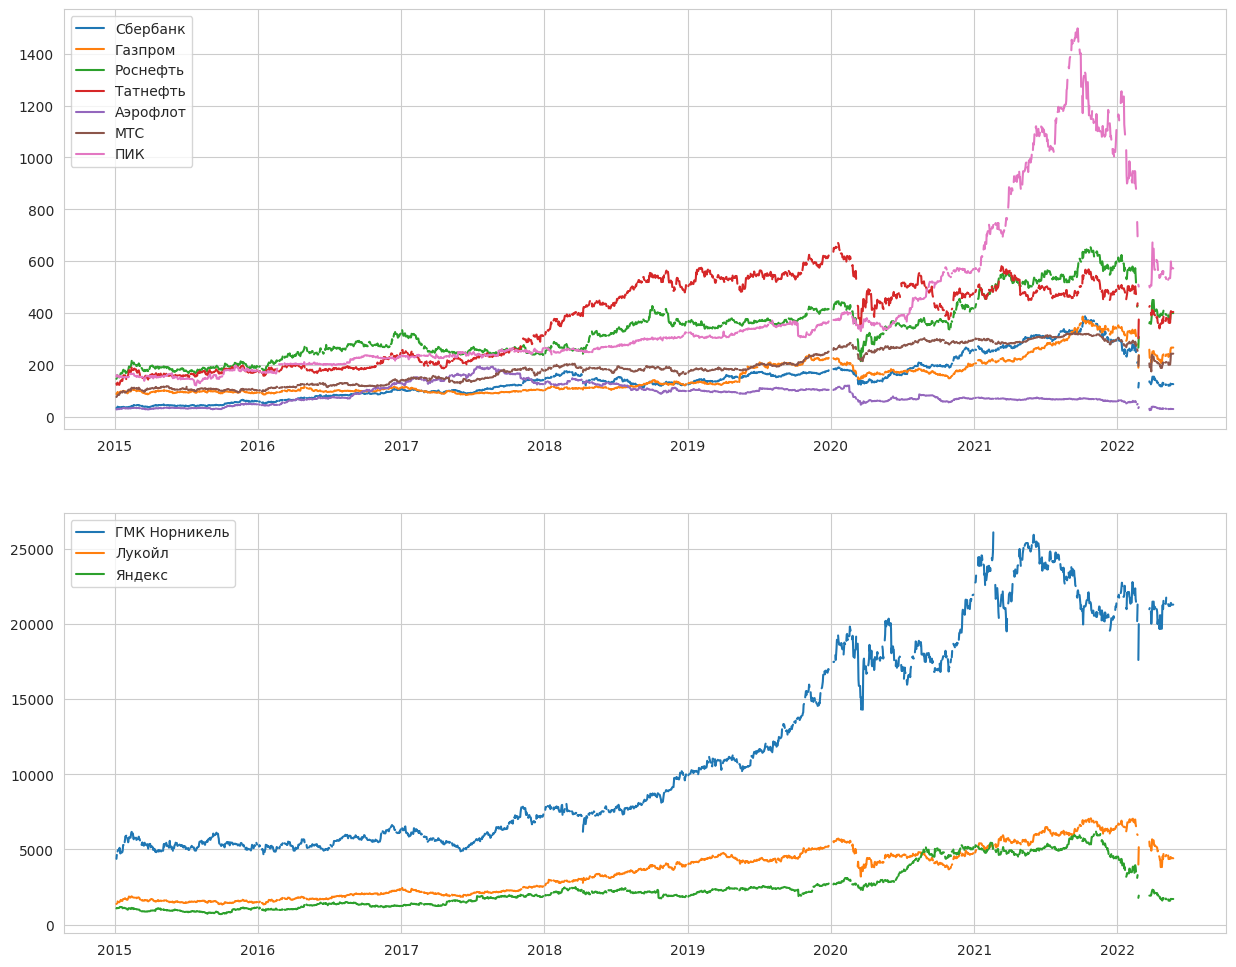

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

for i in ['ГМК Норникель', 'Лукойл', 'Яндекс']:
    axs[1].plot(data[i], label=i)
axs[1].legend()

for i in ['Сбербанк', 'Газпром', 'Роснефть', 'Татнефть', 'Аэрофлот', 'МТС', 'ПИК']:
    axs[0].plot(data[i], label=i)
axs[0].legend()

plt.show()

## Пропуски

In [ ]:
df_null = data.isnull().sum()
df_null = pd.DataFrame(index=df_null.index, columns=['Кол-во пропусков'], data=df_null.values)
df_null['Доля пропусков'] = round(df_null['Кол-во пропусков']/data.shape[0], 2)

In [ ]:
df_null

,Кол-во пропусков,Доля пропусков
Курс доллара,949,0.32
Курс евро,949,0.32
Нефть,713,0.24
МосБиржа,921,0.32
РТС,924,0.32
Золото,949,0.32
Серебро,949,0.32
Платина,949,0.32
КБД 0.25,920,0.31
КБД 0.5,920,0.31


In [ ]:
#data.fillna(method='bfill', inplace=True)
#data.fillna(method='ffill', inplace=True)

## Результат

In [ ]:
# Сохранение результатов
data.to_excel(folder+'Final_data.xlsx')